# Système de Gestion de Base de Données Relationnelles

Le *modèle relationnel* est inventé vers 1970 par [Edgar F. Codd](https://fr.wikipedia.org/wiki/Edgar_Frank_Codd). 

Dès lors apparaissent les premiers SGBD - **S**ystème de **G**estion de **B**ase de **D**onnées - comme **System R** d'IBM, le premier à proposer une implémentation du langage SQL.

Le premier SGBD à vocation commerciale, **ORACLE**, apparait en 1979; il sera suivi de nombreux autres comme DB2 (IBM), SYBASE, INFORMIX (IBM), SQL SERVER (microsoft), MYSQL, POSTGRESQL, ... 

## Rôle d'un SGBD

Un **SGBD** est logiciel complexe, souvent organisé suivant le modèle **client-serveur**.

![img](https://www.researchgate.net/profile/Hong_Kim9/publication/221761402/figure/fig1/AS:213387880472577@1427887043077/A-client-server-architecture-in-a-drug-utilization-review-DUR-data-manage-system-DUR.png)

Bien souvent, l'utilisateur final interragit avec le SGBD via une interface web: le navigateur communique avec un serveur web lequel communique avec le serveur de base de données (SGBD).

Le **rôle** d'un SGBD est d'assurer (entre autres choses):

- la **réalisation effective** des ordres SQL qu'on lui transmet:
    
    - en implémentant des *structures de données* nécessaires à la réalisation des abstractions que sont les tables, domaines, contraintes...
    
    - en organisant l'enregistrement des données sur une mémoire de stockage (disques, bandes, ...)
    
    - en implémentant divers algorithmes efficaces sur les structures de données internes pour pouvoir faire face à des requêtes qui peuvent-être complexes et coûteuses,
    
- la **sûreté** des données contre les pannes matériels par exemple: aller-retour entre la mémoire vive (rapide) et le(s) disque(s) (lent),

- la **sécurité de l'accès** aux données: gestion des utilisateurs, de leurs permissions etc.

- la **gestion des accès concurrents**: différents clients peuvent vouloir accéder et/ou modifier les données au même moment,

- le **contrôle transactionnel**: les ordres sql qui peuvent modifier les données doivent parfois être groupés en transaction sous peine d'incohérence de la base de donnée après exécution:

    - *ex*: Si Alice fait un virement à Bob de 100€, il faut s'assurer que les deux ordres SQL qui vont modifier leurs comptes sont:
        - *soit* exécutés tous les deux sans erreurs,
        - *soit* qu'aucun d'eux n'est exécutés.

Un point important à relever à ce stade au sujet du langage SQL (qui permet de dialoguer avec un tel logiciel) est qu'il est **déclaratif**:
> Avec ce langage, on n'exprime pas **comment** accéder aux données, mais on indique (déclare) le résultat qu'on souhaite obtenir.

Par opposition, un langage comme python est souvent qualifié d'**impératif** parce qu'on doit préciser **comment** obtenir le résultat visé.

Ajoutons enfin que, pour des raisons historiques, le langage SQL, bien que faisant l'objet d'une norme ANSI, admet de nombreux «dialectes» qui dépendent du SGBD utilisé: il est donc nécessaire de *parcourir la documentation du SGBD utilisé* (*rtfd*!) pour en prendre connaissance.

Par la suite, nous parlerons le «dialecte» SQL du SGBD PostgreSQL qui a le mérite d'être:
1. open source [[miroir du dépôt officiel sur github]](https://github.com/postgres/postgres),
2. de suivre d'assez près la norme officiel de SQL.

## Les transactions

Les ordres SQL qui servent à modifier les données - INSERT, UPDATE, DELETE - ont parfois besoin d'être **groupés** de façon à modifier la base de données *sans introduire d'incohérences*.

Pour illustrer ce point, supposons que nous voulions sortir un livre de l'inventaire d'une bibliothèque.

Voici le schéma relationnel de cette bibliothèque:

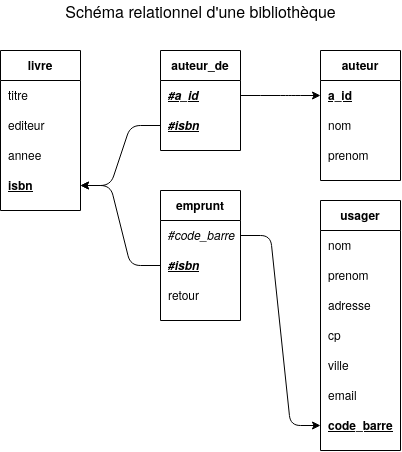

Dans un terminal, créer un base de données temporaire (préfixer son nom par vos initiales pour éviter les conflits) et utiliser le script *biblio.sql* pour l'initialiser:

    createdb <vos_initiales>_biblio # créer la bdd
    psql <vos_initiales>_biblio     # s'y connecter
    => \i biblio.sql                # construire les tables et insérer les données

Explorer un peu les données avant de poursuivre.

Prenons pour exemple le livre:

> *Les aventures de Huckleberry Finn* de **Mark Twain** (ISBN **'978-2081509511'**).

Pour le supprimer de l'inventaire, on pourrait exécuter les ordres SQL suivants:

```sql
DELETE FROM auteur_de WHERE isbn = '978-2081509511';
DELETE FROM auteur
    WHERE NOT (a_id IN (SELECT a_id FROM auteur_de));
DELETE FROM livre WHERE isbn = '978-2081509511';
```

*Note*: le deuxième DELETE peut se lire comme «supprimer toutes les lignes d'auteur non référencées dans la table auteur_de»

L'*ordre* de ces instructions est essentiel afin de respecter les diverses contraintes de clés étrangères.

Clairement, **ces ordres forment un «tout»**: si le deuxième ou 3e ordres échoue, la base de données se trouve dans un état incohérent!

Imaginez qu'un emprunteur (Michel) ait reposé notre livre en rayon *sans avoir enregistré son retour*; nous pouvons simuler cette situation par:

```sql
-- Michel, cet étourdi..
INSERT INTO emprunt VALUES ('199614051174633', '978-2081509511', '2020-11-01'); 
```

Alors les deux premiers ordres sont exécutés mais **pas le troisième** (du fait de la contrainte de clé étrangère de la table *emprunt*): la base de données est dans un état *incohérent* (présence d'un livre mais aucune information sur ces auteurs). Nous obtenons le message:

Recharger à partir du script `\i biblio.sql` pour remettre la bdd dans un état cohérent.

On souhaite donc que, **si l'un des trois ordres échoue, aucun ordre ne soit réalisé** (ou qu'ils soient tous annulés); c'est ce qu'on appelle une **transaction**.

Dans postgresql, on encadre les ordres sql qui forment une transaction par `BEGIN;` et `COMMIT;`:

```sql
BEGIN; -- début d'une transaction
  DELETE FROM auteur_de WHERE isbn = '978-2081509511';
  DELETE FROM auteur
      WHERE NOT (a_id IN (SELECT a_id FROM auteur_de));
  DELETE FROM livre WHERE isbn = '978-2081509511';
COMMIT; -- fin (on peut aussi utiliser ROLLBACK)
```

Si on l'exécute, après avoir simulé la bourde de Michel, psql répond `ROLLBACK` ce qui indique que la transaction n'a pas pu aboutir et que la base de données a été ramenée dans son état précédent: vérifier que Mark Twain est toujours dans la table auteur.

Si on supprime l'emprunt de michel:

```sql
DELETE FROM emprunt WHERE isbn = '978-2081509511';
```

et qu'on exécute à nouveau la transation, psql répond `COMMIT` indiquant que la transaction a aboutie.

Le **contrôle transactionnel** fourni par les SGBD vise à garantir quatres propriétés abrégées dans le sigle **ACID**:

- **Atomicité**: un groupe d'ordres sql est complètement exécuté ou aucun ordre du groupe ne l'est - c'est «tout ou rien»,

- **Cohérence**,

- **Isolation**: si deux transactions s'exécutent *simultanément* (**concurrence**), le résultat obtenu doit-être le même que si elles s'étaient exécutées l'une après l'autre,

- **Durabilité**: Une transaction validée (commit) est immédiatement enregistrée sur une mémoire de stockage et ne peut donc pas être perdue.

## Python et postgresql

Pour communiquer avec postgresql depuis Python, on peut utiliser le module (à installer) **psycopg2**

In [ ]:
import psycopg2 as pg

Son schéma d'utilisation est le suivant (voir [ici pour plus de détails](https://www.psycopg.org/docs/usage.html)):

1. `conn = pg.connect(...)`: se connecter au SGBD,
2. `curs = conn.cursor()`: récupérer un «curseur» à partir de la connexion; il représente un contexte d'exécution pour les requêtes à venir,
3. `curs.execute(<requete sql>)`: exécuter un ordre SQL,
4. `ligne = curs.fetchone()` ou `lignes = curs.fetchall()`: récupérer le résultat de la requête soit ligne par ligne soit toutes les lignes dans une liste. On peut aussi utiliser la syntaxe de boucle `for ligne in curs: ...`,
5. **Traitement** des données récupérées,
6. `curs.close(); conn.close()`: fermer la connexion.

#### Exemple 1

In [ ]:
import psycopg2 as pg

# Ici, la connexion se fait par rapport à votre compte unix sur le hub.
# pour cette raison, il suffit de préciser la base de données.
# Mais en réalité la connexion se fait souvent depuis un autre ordinateur...
conn = pg.connect(
    # host="jhub.fdex.eu", # ou ip du SGBD
    # port=5432,           # 5432 est le port par défaut mais il peut être modifié
    # user="term_nsi",     # nom de l'utilisateur
    # passwd="Nsi#2020",   # son mot de passe
    database="biblio"      # par défaut, même nom que l'utilisateur
)
curs = conn.cursor()

curs.execute("SELECT * FROM livre WHERE annee >= '2000'")

ligne = curs.fetchone()
print(f"première ligne: {ligne}")

print(f"seconde ligne: {curs.fetchone()}")

print("Autres:")
for l in curs: # observer que les données chargées par fetchone ne sont pas relues
    print(f"\t{l}")

curs.close()
conn.close()

#### Exemple 2

Pour insérer des données dans un ordre SQL, on utilise un indicateur spécial `%s` qui représente « une place vide »:

    curs.execute(<ordre sql avec un ou des %s>, <séquence de valeurs de remplacement>)

Il ne faut **surtout pas** utiliser `str.format` ou les *f-strings* pour produire la chaîne SQL!

Enfin, pour récupérer les noms des champs (colonnes):
- `curs.description` est une séquence d'objets de type «Column»...
- ... et chaque «Column» possède un attribut `name`.

Dans cet exemple, on cherche tous les livres dont le titre contient la chaîne saisie par l'utilisateur.

In [ ]:
import psycopg2 as pg

conn = pg.connect(database="biblio")
curs = conn.cursor()

texte = input("Texte à rechercher dans le titre: ")
curs.execute(
    "SELECT * FROM livre WHERE titre LIKE %s",
    [f"%{texte}%"] # le deuxième argument doit-être une «séquence» d'où les crochets!
)
cols = curs.description
for ligne in curs:
    print(f"{cols[0].name}: {ligne[0]}, {cols[2].name}: {ligne[2]}")

curs.close()
conn.close()